In [14]:
import os
import torchvision

from torch import cuda, device, Tensor, save, load, stack, zeros, vstack, reshape, squeeze
from src.plots import plot_vae_training_result, plot_image, plot_image_label_two
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.image_classifier import MNISTClassifier
from src.utils import frechet_inception_distance

device = device('cuda' if cuda.is_available() else 'cpu')

In [15]:
training_data = torchvision.datasets.FashionMNIST(root='../../data/FMNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.FashionMNIST(root='../../data/FMNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(training_data)
print(testing_data)

print(training_data.data.shape)
print(training_data.targets.shape)

input = training_data.data[:60000]
labels = training_data.targets[:60000]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../../data/FMNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../../data/FMNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


Finished epoch:  1
Finished epoch:  2
Finished epoch:  3
Finished epoch:  4
Finished epoch:  5
Finished epoch:  6
Finished epoch:  7
Finished epoch:  8
Finished epoch:  9
Finished epoch:  10


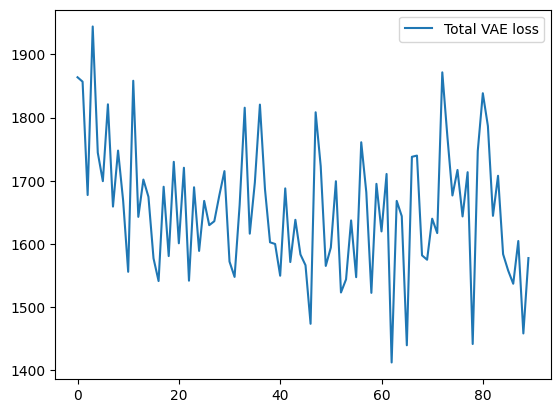

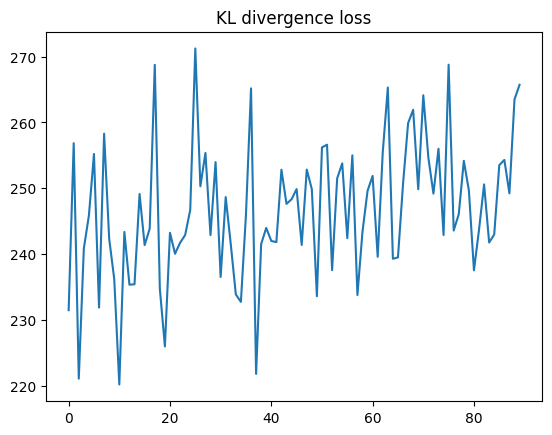

In [17]:
# parameters
model = "cvae"
dataset = "fmnist"
batch_size = 64
epoch = 10
learning_rate = 0.01

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}.pt"

if os.path.exists(model_path):
    vae = load(model_path)
else:
    vae = ConditionalVae(dim_encoding=3).to(device)

    # try with model sigma
    vae_model, vae_loss_li, kl_loss_li = vae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(vae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

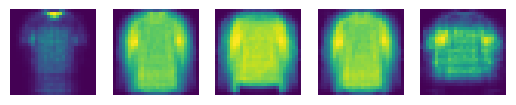

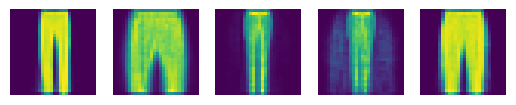

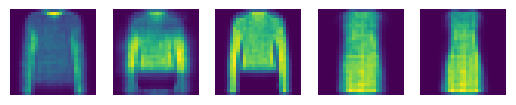

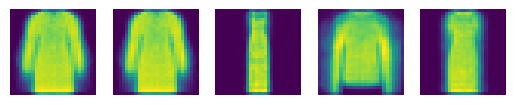

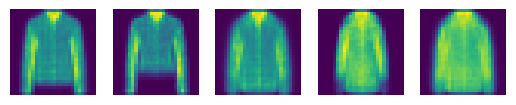

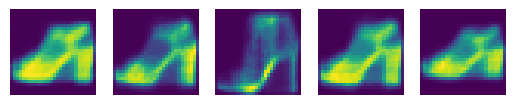

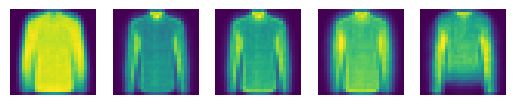

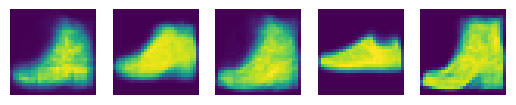

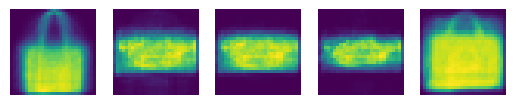

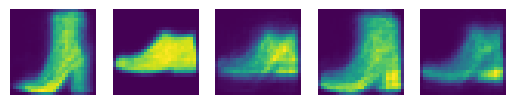

In [18]:
for i in range(10):
    images = vae.generate_data(n_samples=5, target_label=i)
    plot_image(images)

In [19]:
# train classifier for performance evaluation
model = "classifier"
dataset = "fmnist"
batch_size = 64
epoch = 10

classifier_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}.pt"

if os.path.exists(classifier_path):
    classifier = load(classifier_path)
else:
    classifier = MNISTClassifier(input_size=784, num_classes=10)
    classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)
save(classifier, classifier_path)

Test accuracy:  0.8932


In [20]:

# generate data for testing on classifier
# this one stays the same
data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())

final_images = vstack(images)
final_labels = vstack(labels)

assert final_images.shape[0] == final_labels.shape[0]

accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
print("Accuracy: ", accuracy)

Accuracy:  0.7559


In [42]:
# Determine FID
# generate 500 images
# normalizing necessary to make pixels in [0, 1] range for FID

testing_data = torchvision.datasets.MNIST(root='../../data/FMNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

num_data = 100

input = testing_data.data[:num_data] / 255.0
syn_input = vae.generate_data(n_samples=num_data)

input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

# compute FID score
fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
print("Frechet Inception Distance: ", fid_score)

Frechet Inception Distance:  tensor(276.3321)


In [7]:
# test baseline as IID data
num_users = [3, 5, 10]
for num_user in num_users:
    model_state_dict_path = f"../../models/federated_cvae_fmnist_1_1.0_20_2_{num_user}.pt"
    loaded_state_dict = load(model_state_dict_path)
    global_model = ConditionalVae(dim_encoding=3)
    global_model.load_state_dict(loaded_state_dict)
        
    data_count = 10000
    ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    images = []
    labels = []
    
    for label_idx, ratio in enumerate(ratios):
        num_samples_to_generate = int(data_count * ratio)
        images.append(global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
        
        label = zeros((num_samples_to_generate, 10), device=device)
        label[:, label_idx] = 1
        labels.append(label.cpu().detach())
    
    final_images = vstack(images)
    final_labels = vstack(labels)
    
    assert final_images.shape[0] == final_labels.shape[0]
    
    accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
    print(f"IID data num users {num_user} accuracy: ", accuracy)
    # 
    # for i in range(10):
    #     images = global_model.generate_data(n_samples=5, target_label=i)
    #     plot_image(images)

IID data num users 3 accuracy:  0.7729
IID data num users 5 accuracy:  0.7953
IID data num users 10 accuracy:  0.7755


Num user 3, Dirichlet beta 0.1 accuracy:  0.8399
Num user 3, Dirichlet beta 0.2 accuracy:  0.832
Num user 3, Dirichlet beta 0.3 accuracy:  0.7959
Num user 3, Dirichlet beta 0.4 accuracy:  0.8076
Num user 3, Dirichlet beta 0.5 accuracy:  0.8
Num user 3, Dirichlet beta 0.6 accuracy:  0.7996
Num user 3, Dirichlet beta 0.7 accuracy:  0.8004
Num user 3, Dirichlet beta 0.8 accuracy:  0.8189
Num user 3, Dirichlet beta 0.9 accuracy:  0.7967
Num user 3, Dirichlet beta 1.0 accuracy:  0.7829
Num user 5, Dirichlet beta 0.1 accuracy:  0.8138
Num user 5, Dirichlet beta 0.2 accuracy:  0.7965
Num user 5, Dirichlet beta 0.3 accuracy:  0.7999
Num user 5, Dirichlet beta 0.4 accuracy:  0.7535
Num user 5, Dirichlet beta 0.5 accuracy:  0.8012
Num user 5, Dirichlet beta 0.6 accuracy:  0.7817
Num user 5, Dirichlet beta 0.7 accuracy:  0.8041
Num user 5, Dirichlet beta 0.8 accuracy:  0.7742
Num user 5, Dirichlet beta 0.9 accuracy:  0.8004
Num user 5, Dirichlet beta 1.0 accuracy:  0.7893
Num user 10, Dirichlet b

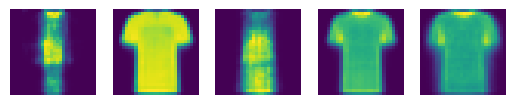

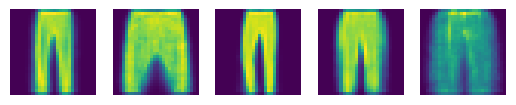

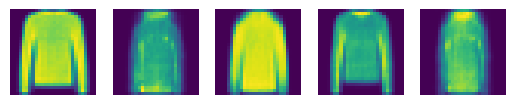

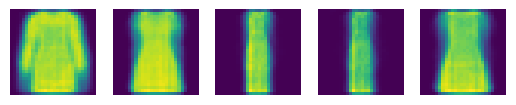

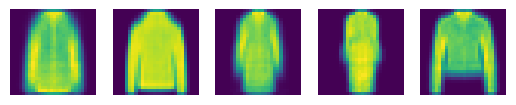

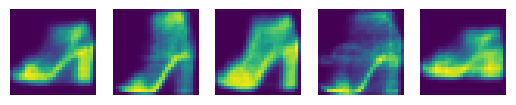

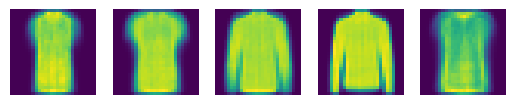

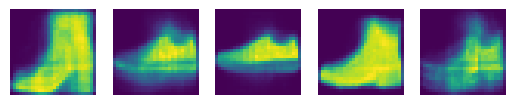

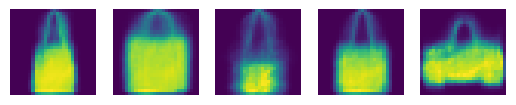

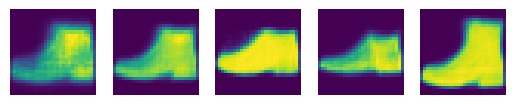

In [8]:
dirichlet_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_users = [3, 5, 10]

for num_user in num_users:
    for dirichlet_ratio in dirichlet_ratios:
        model_state_dict_path = f"../../models/federated_cvae_fmnist_2_{dirichlet_ratio}_20_2_{num_user}.pt"
        loaded_state_dict = load(model_state_dict_path)
        global_model = ConditionalVae(dim_encoding=3)
        global_model.load_state_dict(loaded_state_dict)
            
        data_count = 10000
        ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
        images = []
        labels = []
        
        for label_idx, ratio in enumerate(ratios):
            num_samples_to_generate = int(data_count * ratio)
            images.append(global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
            
            label = zeros((num_samples_to_generate, 10), device=device)
            label[:, label_idx] = 1
            labels.append(label.cpu().detach())
        
        final_images = vstack(images)
        final_labels = vstack(labels)
        
        assert final_images.shape[0] == final_labels.shape[0]
        
        accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
        print(f"Num user {num_user}, Dirichlet beta {dirichlet_ratio} accuracy: ", accuracy)
        
        if num_user == 10 and dirichlet_ratio == 0.1:
            for i in range(10):
                images = global_model.generate_data(n_samples=5, target_label=i)
                plot_image(images)

In [27]:
# train classifier on generated images
data_count = 600000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())
final_images = vstack(images)
final_labels = vstack(labels)

training_data = torchvision.datasets.FashionMNIST(root='../../data/FMNIST_train', train=True, download=True,
                                                  transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.FashionMNIST(root='../../data/FMNIST_test', train=False, download=True,
                                                 transform=torchvision.transforms.ToTensor())
training_data.data = squeeze(final_images, dim=1)
training_data.targets = final_labels.argmax(dim=1)

print(training_data.data.shape)
print(training_data.targets.shape)

torch.Size([600000, 28, 28])
torch.Size([600000])


In [ ]:
# train classifier for performance evaluation
batch_size = 64
epoch = 10

classifier = MNISTClassifier(input_size=784, num_classes=10)
classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)

accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1
Epoch done:  2
Epoch done:  3
